In [11]:
# =========== IMPORT LIBRARIES ============
import sys
import numpy as np
import network as Network_library
import data as Data
import pickle
import matplotlib.pyplot as plt
import pandas as pd
# =========== BUILD A CLASSIFIER ============
# we start by using the classifier defined in the class 
# however we define it as a function which will return accuracy of the model

def reservoir_class(test_name, filter_name, classifier, num_nodes, input_probability, reservoir_probability):
    """
    Conducts reservoir computing for classification tasks on specified datasets.

    Parameters:
        test_name (str): Name of the test dataset. Supported values are '5s' and 'lvr'.
        filter_name (str): Name of the frequency band for data filtering.
                           Must be one of the keys in the spectral_bands dictionary.
        classifier (str): Type of classifier to use. Supported values are 'lin', 'log', and '1nn'.
        num_nodes (int): Number of nodes in the reservoir layer.
        input_probability (float): Probability of non-zero input connections in the reservoir.
        reservoir_probability (float): Probability of non-zero recurrent connections in the reservoir.

    Raises:
        ValueError: If the specified test, classifier, or filter is not supported.

    Returns:
        Accuracy
    """
    d = Data.Data(80) #80% training 20% testing

    Network = Network_library.Network()

    #Setting the right data for all the possible combinations of problems and classifiers

    if test_name == '5s':
        d.import_data('dataSorted_allOrientations.mat')
        if classifier == 'lin':
            d.build_train_labels_lin()
            d.build_test_labels_lin()
            
        elif classifier == 'log':
            d.build_train_labels_log()
            d.build_test_labels_log()

        else:
            print("This classifier is not supported for this test.")
            sys.exit(1)

        d.build_training_matrix()
        d.build_test_matrix()
        Network.L = 5

    elif test_name == 'lvr':
        if classifier == 'log' or classifier == '1nn':
            d.import_data('dataSorted_leftAndRight.mat')
            d.leftvsright_mixed()
            Network.L = 1

        else: 
            print("This classifier is not supported for this test.")
            sys.exit(1)

    else:
        print("This test does not exist.")
        sys.exit(1)

    #Filtering the data
    if filter_name not in d.spectral_bands.keys():
        print("The specified frequency band is not supported")
        sys.exit(1)

    d.training_data = d.filter_data(d.training_data,filter_name)
    d.test_data = d.filter_data(d.test_data,filter_name)


    #Computing the absolute value of the data, to get rid of negative numbers
    d.training_data = np.abs(d.training_data)
    d.test_data = np.abs(d.test_data)

    ########################
    # Define the network parameters
    ########################

    Network.T = d.training_data.shape[1] #Number of training time steps
    Network.n_min = 2540 #Number time steps dismissed
    Network.K = 128 #Input layer size
    Network.N = num_nodes #Reservoir layer size


    Network.u = d.training_data
    Network.y_teach = d.training_results

    Network.setup_network(d,num_nodes,input_probability,reservoir_probability,d.data.shape[-1])

    Network.train_network(d.data.shape[-1],classifier,d.num_columns, d.num_trials_train, d.train_labels, Network.N) 

    Network.mean_test_matrix = np.zeros([Network.N,d.num_trials_test,d.data.shape[-1]])

    Network.test_network(d.test_data, d.num_columns,d.num_trials_test, Network.N, d.data.shape[-1], t_autonom=d.test_data.shape[1])

    if classifier == 'lin':
        #print(f'Performance for {test_name} using {classifier} : {d.accuracy_lin(Network.regressor.predict(Network.mean_test_matrix.T),d.test_labels)}')
        return d.accuracy_lin(Network.regressor.predict(Network.mean_test_matrix.T),d.test_labels)
    elif classifier == 'log':
        #print(f'Performance for {test_name} using {classifier} : {Network.regressor.score(Network.mean_test_matrix.T,d.test_labels.T)}')
        return Network.regressor.score(Network.mean_test_matrix.T,d.test_labels.T)
    elif classifier == '1nn':
        #print(f'Performance for {test_name} using {classifier} : {Network.regressor.score(Network.mean_test_matrix.T,d.test_labels)}')
        return Network.regressor.score(Network.mean_test_matrix.T,d.test_labels)

In [12]:
# =========== SET UP PARAMETERS ============
# the parameters we are interested and will investigate in in this assignment are
# num_nodes, input_probability, reservoir_probability

# For that we will create grid search function with different parameters values and
# observe what happens to the accuracy of the model.

# Why not other parameters? 
# First of all, we have just one .mat file, thus we can only use 5s
# We could potentionally try different filter_names as by printing we have various options
# print(d.spectral_bands.keys())- 'theta', 'alpha', 'beta', 'lowgamma', 'highgamma', 'lowripple', 'highripple',  'baseline', 'lowmultiunit'
# However that is out of the scope of the assignment

# There are few obstacles we had to face: 
# input_probobability must be number up till 0.3 since then we got NaN values and errors arose
# this is connected with the row in network.py, line 73: alpha = 0.22/max(abs(scipy.linalg.eigvals(self.W))) 
# =========== GRID SEARCH FOR PARAMETERS ============
filter_name = ['lowmultiunit'] 
num_nodes = np.arange(10,150,20)
input_probability = np.arange(0.1,0.3,0.1)
reservoir_probability = np.arange(0.1,1,0.2)
# Dictionary to store results
results = {}

# Iterate over each combination of parameters
for filter in filter_name:
    for nodes in num_nodes:
        for input_prob in input_probability:
            for reservoir_prob in reservoir_probability:
                print('Values: ','5s', filter, 'lin', nodes, input_prob, reservoir_prob)
                # Call the reservoir_class function with the current parameter combination
                result = reservoir_class('5s', filter, 'lin', nodes, input_prob, reservoir_prob)
                
                # Store the result in the dictionary
                results[(filter, nodes, input_prob, reservoir_prob)] = result


Values:  5s lowmultiunit lin 10 0.1 0.1
Total of (128, 508, 140, 5)
Values:  5s lowmultiunit lin 10 0.1 0.30000000000000004
Total of (128, 508, 140, 5)
Values:  5s lowmultiunit lin 10 0.1 0.5000000000000001
Total of (128, 508, 140, 5)
Values:  5s lowmultiunit lin 10 0.1 0.7000000000000001
Total of (128, 508, 140, 5)
Values:  5s lowmultiunit lin 10 0.1 0.9000000000000001
Total of (128, 508, 140, 5)
Values:  5s lowmultiunit lin 10 0.2 0.1
Total of (128, 508, 140, 5)
Values:  5s lowmultiunit lin 10 0.2 0.30000000000000004
Total of (128, 508, 140, 5)
Values:  5s lowmultiunit lin 10 0.2 0.5000000000000001
Total of (128, 508, 140, 5)
Values:  5s lowmultiunit lin 10 0.2 0.7000000000000001
Total of (128, 508, 140, 5)
Values:  5s lowmultiunit lin 10 0.2 0.9000000000000001
Total of (128, 508, 140, 5)
Values:  5s lowmultiunit lin 30 0.1 0.1
Total of (128, 508, 140, 5)
Values:  5s lowmultiunit lin 30 0.1 0.30000000000000004
Total of (128, 508, 140, 5)
Values:  5s lowmultiunit lin 30 0.1 0.50000000

In [13]:
# =========== STORE RESULTS ============
# store the results so we do not need to run the grid search again
with open('results.pickle', 'wb') as file:
    pickle.dump(results, file)

In [14]:
# =========== SEE THE RESULTS ============
with open('results.pickle', 'rb') as file:
    results = pickle.load(file)
print(results)

{('lowmultiunit', 10, 0.1, 0.1): 0.6928571428571428, ('lowmultiunit', 10, 0.1, 0.30000000000000004): 0.55, ('lowmultiunit', 10, 0.1, 0.5000000000000001): 0.6857142857142857, ('lowmultiunit', 10, 0.1, 0.7000000000000001): 0.7285714285714285, ('lowmultiunit', 10, 0.1, 0.9000000000000001): 0.6857142857142857, ('lowmultiunit', 10, 0.2, 0.1): 0.7214285714285714, ('lowmultiunit', 10, 0.2, 0.30000000000000004): 0.6857142857142857, ('lowmultiunit', 10, 0.2, 0.5000000000000001): 0.65, ('lowmultiunit', 10, 0.2, 0.7000000000000001): 0.6142857142857143, ('lowmultiunit', 10, 0.2, 0.9000000000000001): 0.5714285714285714, ('lowmultiunit', 30, 0.1, 0.1): 0.8857142857142857, ('lowmultiunit', 30, 0.1, 0.30000000000000004): 0.8571428571428571, ('lowmultiunit', 30, 0.1, 0.5000000000000001): 0.8642857142857143, ('lowmultiunit', 30, 0.1, 0.7000000000000001): 0.8642857142857143, ('lowmultiunit', 30, 0.1, 0.9000000000000001): 0.8785714285714286, ('lowmultiunit', 30, 0.2, 0.1): 0.7928571428571428, ('lowmultiun

In [16]:
# Initialize lists to store each column
filter_name_list = []
num_nodes_list = []
input_probability_list = []
reservoir_probability_list = []
accuracy_list = []

# Iterate through the results dictionary and populate the lists
for (filter_name, num_nodes, input_prob, reservoir_prob), accuracy in results.items():
    filter_name_list.append(filter_name)
    num_nodes_list.append(num_nodes)
    input_probability_list.append(input_prob)
    reservoir_probability_list.append(reservoir_prob)
    accuracy_list.append(accuracy)

# Create a DataFrame from the lists
df = pd.DataFrame({
    'filter_name': filter_name_list,
    'num_nodes': num_nodes_list,
    'input_probability': input_probability_list,
    'reservoir_probability': reservoir_probability_list,
    'accuracy': accuracy_list
})

In [18]:
df

,filter_name,num_nodes,input_probability,reservoir_probability,accuracy
0,lowmultiunit,10,0.1,0.1,0.692857
1,lowmultiunit,10,0.1,0.3,0.550000
2,lowmultiunit,10,0.1,0.5,0.685714
3,lowmultiunit,10,0.1,0.7,0.728571
4,lowmultiunit,10,0.1,0.9,0.685714
...,...,...,...,...,...
65,lowmultiunit,130,0.2,0.1,0.964286
66,lowmultiunit,130,0.2,0.3,0.957143
67,lowmultiunit,130,0.2,0.5,0.985714
68,lowmultiunit,130,0.2,0.7,0.978571


In [21]:
def calculate_accuracy_variance(df, group_by_columns):
    """
    Calculate the variance of accuracy based on the specified group-by columns.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    group_by_columns (list): The columns to group by.

    Returns:
    DataFrame: A DataFrame with the variance of accuracy for each group.
    """
    # Group by the specified columns and calculate variance of the accuracy
    accuracy_variance = df.groupby(group_by_columns)['accuracy'].var()
    
    # Reset index to turn the groupby object back into a DataFrame
    accuracy_variance = accuracy_variance.reset_index()
    
    # Rename the variance column for clarity
    column_name = '_'.join(group_by_columns) + '_accuracy_variance'
    accuracy_variance.rename(columns={'accuracy': column_name}, inplace=True)
    
    return accuracy_variance

In [22]:
# Calculate variance for 'num_nodes'
num_nodes_variance = calculate_accuracy_variance(df, ['num_nodes'])
print(num_nodes_variance)

# Calculate variance for 'input_probability'
input_probability_variance = calculate_accuracy_variance(df, ['input_probability'])
print(input_probability_variance)

# Calculate variance for 'reservoir_probability'
reservoir_probability_variance = calculate_accuracy_variance(df, ['reservoir_probability'])
print(reservoir_probability_variance)

# Calculate variance for 'filter_name'
filter_name_variance = calculate_accuracy_variance(df, ['filter_name'])
print(filter_name_variance)

# Calculate variance for multiple parameters
multi_param_variance = calculate_accuracy_variance(df, ['filter_name', 'num_nodes'])
print(multi_param_variance)

   num_nodes  num_nodes_accuracy_variance
0         10                     0.003739
1         30                     0.000919
2         50                     0.000100
3         70                     0.000172
4         90                     0.000082
5        110                     0.000116
6        130                     0.000113
   input_probability  input_probability_accuracy_variance
0                0.1                             0.010466
1                0.2                             0.012184
   reservoir_probability  reservoir_probability_accuracy_variance
0                    0.1                                 0.008396
1                    0.3                                 0.014997
2                    0.5                                 0.011004
3                    0.7                                 0.011170
4                    0.9                                 0.013554
    filter_name  filter_name_accuracy_variance
0  lowmultiunit                       0.011162


In [23]:
def plot_accuracy_variance(df, group_by_columns, title):
    """
    Plot the variance of accuracy based on the specified group-by columns.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    group_by_columns (list): The columns to group by.
    title (str): The title for the plot.
    """
    # Calculate the variance using the previously defined function
    variance_df = calculate_accuracy_variance(df, group_by_columns)
    
    # Determine the name of the variance column
    variance_column_name = '_'.join(group_by_columns) + '_accuracy_variance'
    
    # Plot the variance
    plt.figure(figsize=(10, 6))
    plt.plot(variance_df[group_by_columns], variance_df[variance_column_name], marker='o')
    
    plt.xlabel(' & '.join(group_by_columns))
    plt.ylabel('Accuracy Variance')
    plt.title(title)
    plt.grid(True)
    plt.show()

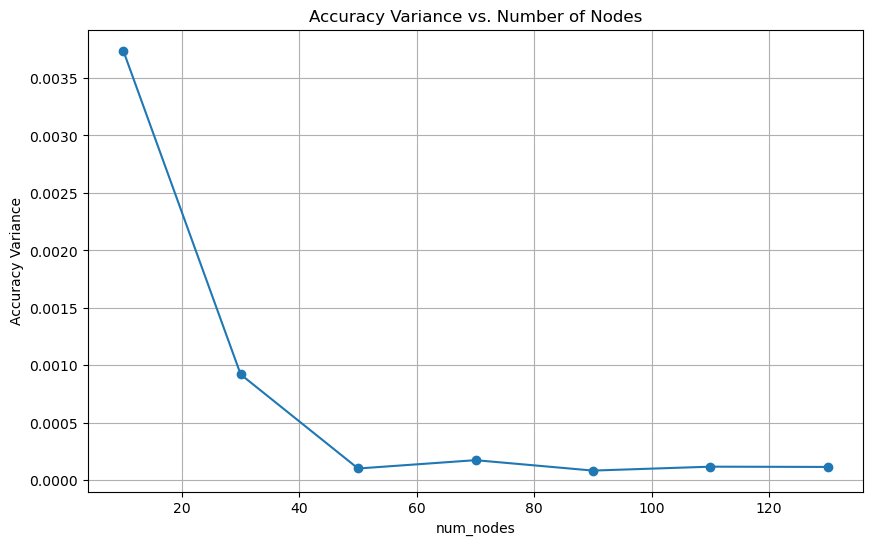

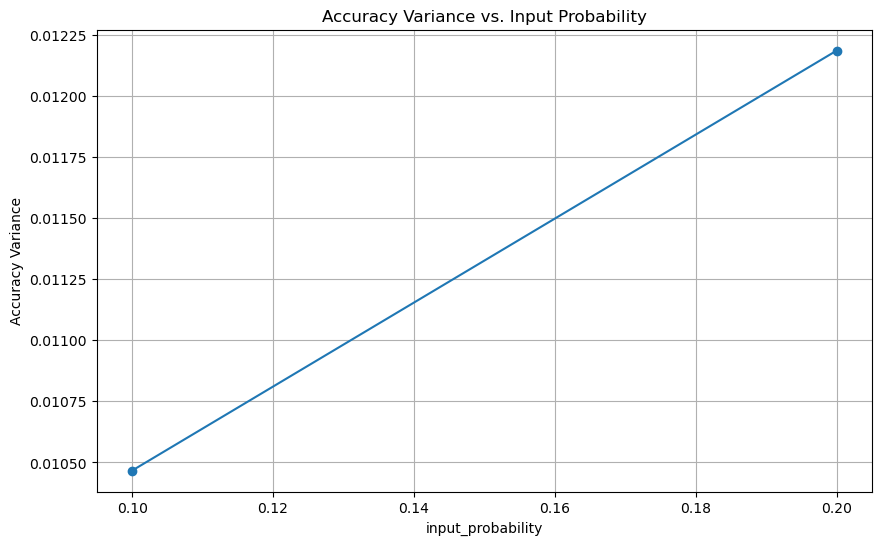

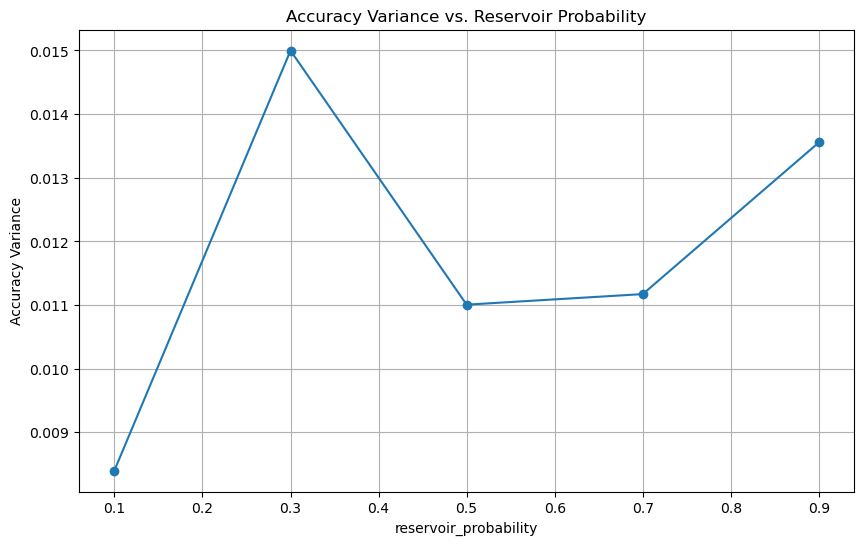

In [26]:
# Plot variance for 'num_nodes'
plot_accuracy_variance(df, ['num_nodes'], 'Accuracy Variance vs. Number of Nodes')

# Plot variance for 'input_probability'
plot_accuracy_variance(df, ['input_probability'], 'Accuracy Variance vs. Input Probability')

# Plot variance for 'reservoir_probability'
plot_accuracy_variance(df, ['reservoir_probability'], 'Accuracy Variance vs. Reservoir Probability')


In [27]:
def calculate_max_accuracy(df, group_by_columns):
    """
    Calculate the maximum accuracy based on the specified group-by columns.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    group_by_columns (list): The columns to group by.

    Returns:
    DataFrame: A DataFrame with the maximum accuracy for each group.
    """
    # Group by the specified columns and calculate the maximum accuracy
    max_accuracy = df.groupby(group_by_columns)['accuracy'].max()
    
    # Reset index to turn the groupby object back into a DataFrame
    max_accuracy = max_accuracy.reset_index()
    
    # Rename the max column for clarity
    column_name = '_'.join(group_by_columns) + '_max_accuracy'
    max_accuracy.rename(columns={'accuracy': column_name}, inplace=True)
    
    return max_accuracy


In [28]:
# Calculate max accuracy for 'num_nodes'
num_nodes_max_accuracy = calculate_max_accuracy(df, ['num_nodes'])
print(num_nodes_max_accuracy)

# Calculate max accuracy for 'input_probability'
input_probability_max_accuracy = calculate_max_accuracy(df, ['input_probability'])
print(input_probability_max_accuracy)

# Calculate max accuracy for 'reservoir_probability'
reservoir_probability_max_accuracy = calculate_max_accuracy(df, ['reservoir_probability'])
print(reservoir_probability_max_accuracy)

# Calculate max accuracy for 'filter_name'
filter_name_max_accuracy = calculate_max_accuracy(df, ['filter_name'])
print(filter_name_max_accuracy)

# Calculate max accuracy for multiple parameters
multi_param_max_accuracy = calculate_max_accuracy(df, ['filter_name', 'num_nodes'])
print(multi_param_max_accuracy)

   num_nodes  num_nodes_max_accuracy
0         10                0.728571
1         30                0.907143
2         50                0.928571
3         70                0.957143
4         90                0.964286
5        110                0.978571
6        130                0.985714
   input_probability  input_probability_max_accuracy
0                0.1                        0.985714
1                0.2                        0.985714
   reservoir_probability  reservoir_probability_max_accuracy
0                    0.1                            0.964286
1                    0.3                            0.985714
2                    0.5                            0.985714
3                    0.7                            0.978571
4                    0.9                            0.978571
    filter_name  filter_name_max_accuracy
0  lowmultiunit                  0.985714
    filter_name  num_nodes  filter_name_num_nodes_max_accuracy
0  lowmultiunit         10      